In [6]:
import random
import re
from collections import Counter

import gensim.downloader as api
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from IPython.display import clear_output
from torch.nn.utils.rnn import pad_sequence
from torch.optim import Adam
from torch.optim import Optimizer
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from tqdm import tqdm


class Vocabulary:

    def __init__(self, texts: list[str], min_freq: int = 10):
        text = ' '.join(texts)

        text = re.sub(r"http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+", " ", text)
        text = re.sub("[^a-zA-Z]", " ", text)

        while '  ' in text:
            text = text.replace('  ', ' ')

        words = text.strip().lower().split()

        c = Counter(words)

        self.vocabulary = list(set([word for word in words if c[word] >= min_freq]))
        self.vocabulary.append('<unk>')
        self.vocabulary.append('<pad>')

        self._idx2word = {i: word for i, word in enumerate(self.vocabulary)}
        self._word2idx = {word: i for i, word in enumerate(self.vocabulary)}

    def idx2word(self, idx: int):
        if idx not in self._idx2word:
            return '<unk>'

        return self._idx2word[idx]

    def word2idx(self, word: str):
        word = word.lower()

        if word not in self._word2idx:
            return self._word2idx['<unk>']

        return self._word2idx[word]

    def encode(self, text):
        result = []

        for word in text.split():
            result.append(self.word2idx(word))

        return result

    def get_pad(self):
        return self.word2idx('<pad>')

    def build_vectors(self, fasttext):
        vectors = []

        for word in self.vocabulary:
            if fasttext.has_index_for(word):
                vectors.append(fasttext[word])
            else:
                vectors.append(np.zeros(25))

        return np.stack(vectors)


class IMDB(Dataset):

    def __init__(self, df, vocab):
        self.df = df

        self.vocab = vocab

        self.label2idx = {
            'positive': 0,
            'negative': 1
        }

    def __getitem__(self, idx):
        text = self.df['review'].loc[idx]
        label = self.label2idx[self.df['sentiment'].loc[idx]]

        text = torch.LongTensor(self.vocab.encode(text))
        label = torch.FloatTensor([label])

        return text, label

    def __len__(self):
        return len(self.df)


class TextCNN(nn.Module):

    def __init__(self, vocab_size: int, embedding_dim: int, pad_idx):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)

        self.convs = nn.ModuleList(
            [
                nn.Conv2d(
                    in_channels=1,
                    out_channels=32,
                    kernel_size=(fs, embedding_dim))
                for fs in [2, 3, 4, 5, 6]
            ]
        )

        self.fc = nn.Linear(5 * 32, 1)

        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.embedding(x)
        x = x.unsqueeze(1)

        x = [F.relu(conv(x)).squeeze(3) for conv in self.convs]

        x = [F.max_pool1d(_, _.shape[2]).squeeze(2) for _ in x]

        x = self.dropout(torch.cat(x, dim=1))

        return self.fc(x)


def set_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)


def binary_accuracy(preds, y):
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float()
    acc = correct.sum() / len(correct)
    return acc


def train(
        model: nn.Module,
        data_loader: DataLoader,
        optimizer: Optimizer,
        loss_fn,
        device: torch.device
):
    model.train()

    train_loss = 0
    train_accuracy = 0

    for x, y in tqdm(data_loader, desc='Train'):
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()

        output = model(x)

        loss = loss_fn(output, y)

        train_loss += loss.item()
        train_accuracy += binary_accuracy(output, y).item()

        loss.backward()

        optimizer.step()

    train_loss /= len(data_loader)
    train_accuracy /= len(data_loader)

    return train_loss, train_accuracy


@torch.inference_mode()
def evaluate(
        model: nn.Module,
        data_loader: DataLoader,
        loss_fn,
        device: torch.device
):
    model.eval()

    total_loss = 0
    total_accuracy = 0

    for x, y in tqdm(data_loader, desc='Evaluation'):
        x, y = x.to(device), y.to(device)

        output = model(x)

        loss = loss_fn(output, y)

        total_loss += loss.item()
        total_accuracy += binary_accuracy(output, y).item()

    total_loss /= len(data_loader)
    total_accuracy /= len(data_loader)

    return total_loss, total_accuracy


def plot_stats(
        train_loss: list[float],
        valid_loss: list[float],
        train_accuracy: list[float],
        valid_accuracy: list[float],
        title: str
):
    plt.figure(figsize=(16, 8))

    plt.title(title + ' loss')

    plt.plot(train_loss, label='Train loss')
    plt.plot(valid_loss, label='Valid loss')
    plt.legend()
    plt.grid()

    plt.show()

    plt.figure(figsize=(16, 8))

    plt.title(title + ' accuracy')

    plt.plot(train_accuracy, label='Train accuracy')
    plt.plot(valid_accuracy, label='Valid accuracy')
    plt.legend()
    plt.grid()

    plt.show()


def whole_train_valid_cycle(
        model,
        train_loader,
        valid_loader,
        optimizer,
        loss_fn,
        device,
        threshold,
        title
):
    train_loss_history, valid_loss_history = [], []
    train_accuracy_history, valid_accuracy_history = [], []

    for epoch in range(100):
        train_loss, train_accuracy = train(
            model, train_loader, optimizer, loss_fn, device
        )
        valid_loss, valid_accuracy = evaluate(model, valid_loader, loss_fn, device)

        train_loss_history.append(train_loss)
        valid_loss_history.append(valid_loss)

        train_accuracy_history.append(train_accuracy)
        valid_accuracy_history.append(valid_accuracy)

        clear_output(wait=True)

        plot_stats(
            train_loss_history,
            valid_loss_history,
            train_accuracy_history,
            valid_accuracy_history,
            title,
        )

        if valid_accuracy >= threshold:
            break


@torch.inference_mode()
def predict(model: nn.Module, loader: DataLoader, device: torch.device):
    model.eval()

    prediction = []

    for x, _ in loader:
        output = model(x.to(device)).cpu()

        prediction.append(torch.round(torch.sigmoid(output)))

    prediction = torch.cat(prediction).ravel()

    return prediction

def save_model(model, optimizer, path):
    # Сохранение модели и состояния оптимизатора
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }, path)
    print(f"Модель сохранена в файл '{path}'")

def load_model(model, optimizer, path):
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    print("Модель и оптимизатор загружены.")
    return model, optimizer


def main(threshold, title):
    set_seed(0xDEADF00D)

    df = pd.read_csv('/kaggle/input/imdb-class/IMDB Dataset.csv')
    df_train, df_test = np.split(df, [45000], axis=0)
    
    df_train.reset_index(drop=True, inplace=True)
    df_test.reset_index(drop=True, inplace=True)

    vocab = Vocabulary(df['review'].values, min_freq=5)

    train_dataset = IMDB(df_train, vocab)
    test_dataset = IMDB(df_test, vocab)

    pad_idx = vocab.get_pad()

    def collate_fn(batch):
        texts = pad_sequence([b[0] for b in batch], padding_value=pad_idx, batch_first=True)
        labels = torch.stack([b[1] for b in batch])

        return texts, labels

    train_loader = DataLoader(train_dataset, batch_size=64, collate_fn=collate_fn, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=64, collate_fn=collate_fn, pin_memory=True)

    vectors = vocab.build_vectors(api.load('glove-twitter-25'))

    model = TextCNN(vocab_size=len(vocab.vocabulary), embedding_dim=25, pad_idx=pad_idx)

    model.embedding.weight.data[:len(vectors)] = torch.from_numpy(vectors)

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    model = model.to(device)

    optimizer = Adam(model.parameters(), lr=1e-3)

    loss_fn = nn.BCEWithLogitsLoss()

    whole_train_valid_cycle(model, train_loader, test_loader, optimizer, loss_fn, device, threshold, title)
    prediction = predict(model, test_loader, device).round().flatten().to('cpu')

    torch.save(prediction, 'prediction.pt')

    save_model(model, optimizer, 'textcnn_model.pth')

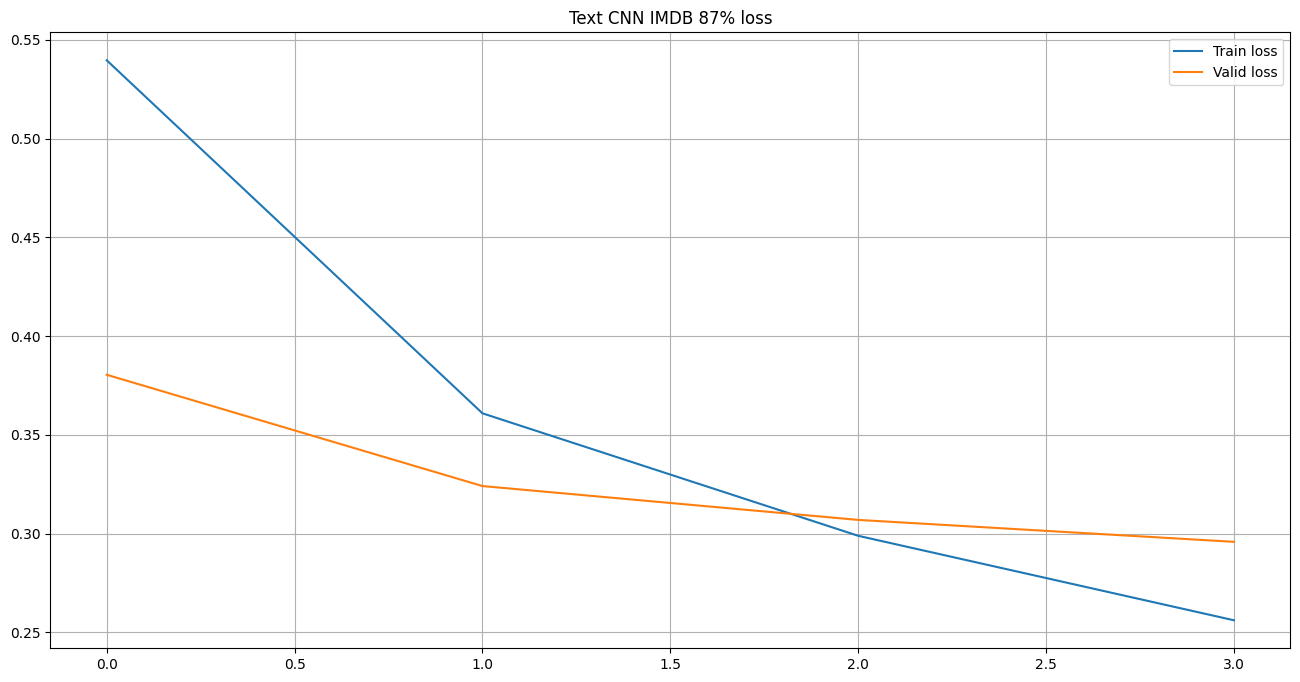

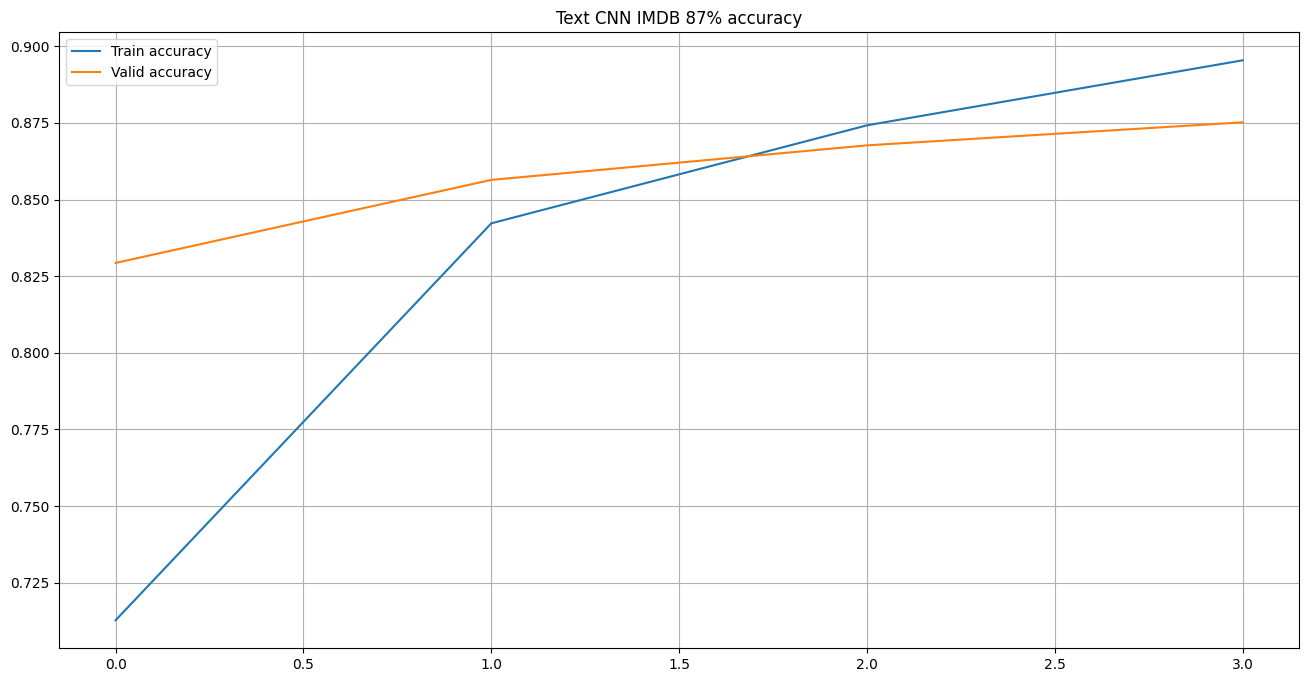

Модель сохранена в файл 'textcnn_model.pth'


In [7]:
main(0.87, 'Text CNN IMDB 87%')

In [13]:
# Убедитесь, что текст достаточно длинный, иначе добавьте паддинг
def predict_text(model, text, vocab, device, max_len=100):
    # Преобразуем текст в индексы
    encoded_text = vocab.encode(text)
    
    # Ограничиваем длину текста (или добавляем паддинг)
    if len(encoded_text) < max_len:
        encoded_text = encoded_text + [vocab.get_pad()] * (max_len - len(encoded_text))

    # Преобразуем в тензор и добавляем размерность для батча
    encoded_text = torch.LongTensor(encoded_text).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        output = model(encoded_text)
        prediction = torch.round(torch.sigmoid(output)).item()  # Преобразуем в 0 или 1
    
    return prediction


In [10]:
# Загрузка необходимых библиотек
import torch
from torch.optim import Adam
import gensim.downloader as api

# Загрузка файла CSV для восстановления данных (или используйте уже имеющийся DataFrame df)
import pandas as pd
df = pd.read_csv('/kaggle/input/imdb-class/IMDB Dataset.csv')

# Инициализация объекта vocab
vocab = Vocabulary(df['review'].values, min_freq=5)  # Используйте данные для создания словаря

# Загрузка модели
model = TextCNN(vocab_size=len(vocab.vocabulary), embedding_dim=25, pad_idx=vocab.get_pad())
optimizer = Adam(model.parameters(), lr=1e-3)

# Загрузка сохраненной модели
model, optimizer = load_model(model, optimizer, '/kaggle/working/textcnn_model.pth')

# Пример отзыва для предсказания
review = "I loved this movie! It was amazing and heartwarming."

# Прогноз
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
prediction = predict_text(model, review, vocab, device)

print(f"Предсказание: {'Положительный' if prediction == 0 else 'Отрицательный'} отзыв")


Модель и оптимизатор загружены.
Предсказание: Положительный отзыв


<ipython-input-6-9873c15ce132>:309: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path)


In [14]:
# Пример нового отзыва
review = "This film was awesome" 

# Прогноз для нового отзыва
prediction = predict_text(model, review, vocab, device)

print(f"Предсказание: {'Положительный' if prediction == 0 else 'Отрицательный'} отзыв")

Предсказание: Положительный отзыв
